# Cookie Cats A-B Testing

<div style="text-align: center;">
    <img src = "https://tactilegames.com/wp-content/uploads/2023/03/TT_Header_CookieCats_UW_Up-scaled.webp" alt="Cookie" style="width: 1000px;" />
</div>

<span style="font-size: 20px;"><b> Use Case: A/B Testing for Cookie Cats Game Onboarding </span>

<span style="font-size: 20px;"> __Objective:__ </span> <br> <span style="font-size: 18px;"> Determine which starting gate (Gate 30 or Gate 40) leads to better user engagement and retention in the Cookie Cats game. </span>

<span style="font-size: 20px;"> __Scenario:__ </span> <br> <span style="font-size: 18px;"> __Cookie Cats__ wants to optimize the onboarding experience by testing two different starting gates to see which one keeps players engaged longer.</span>

<span style="font-size: 20px;"> __Approach:__ </span>

<span style="font-size: 18px;">
  <ul>
        <li><b>Target Audience:</b> New players of the Cookie Cats game.</li>
        <li><b>Starting Gates:</b> Two versions of the starting gate (Gate A and Gate B).</li>
        <li><b>Metrics:</b> Key performance indicators (KPIs) include user engagement (time spent in the game), retention rate, and in-game purchases.</li>
  </ul>
</span>

<span style="font-size: 20px;"> __Execution:__ </span>

<span style="font-size: 18px;">
  <ul>
      <li><b>Random Assignment:</b> New players are randomly assigned to start the game at either Gate A or Gate B.</li>
      <li><b>Data Collection:</b> Track user behavior and engagement metrics for both groups over a specified period.</li>
  </ul>
</span>

# Libraries, directories and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [3]:
# Adjusting columns size and width

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.width', None)  # Adjust display width

In [4]:
# Load data

In [5]:
data = pd.read_csv("Cookie_Cats_cleaned_v01.csv")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# EDA and Cleaning

In [6]:
print ("The number of rows are:", data.shape[0])
print ("The number of columns are:", data.shape[1])

The number of rows are: 90189
The number of columns are: 5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [8]:
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [9]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [10]:
data[data.duplicated()]

,userid,version,sum_gamerounds,retention_1,retention_7


In [11]:
print(f'Features: {data.columns.tolist()}')
print(f'Missing Values: {data.isnull().values.sum()}')
print(f'Unique Values: \n\n{data.nunique()}')

Features: ['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7']
Missing Values: 0
Unique Values: 

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64


In [12]:
# Drop userid as it will not be necessary

In [13]:
# Remove any unnecessary column
data.drop('userid', axis = 1, inplace = True)
print(data.columns)

Index(['version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')


In [16]:
# Check the number of unique values (levels) and their counts in each categorical variable
# Function to return categorical columns with value counts less than a specified number
def filter_categorical_columns(df, threshold):
    categorical_columns = df.select_dtypes(include=['object', 'category', 'number', 'bool'])
    result = []
    for col in categorical_columns:
        if df[col].nunique() <= threshold:
            result.append(col)
    return result

In [17]:
threshold = 3
cat_col = filter_categorical_columns(data, threshold)
print(cat_col)

['version', 'retention_1', 'retention_7']


In [18]:
# Check the number of unique values (levels) and their counts in each categorical variable
categorical_columns = ['version', 'retention_1', 'retention_7']
for col in categorical_columns:
    print(f"\n{data[col].value_counts()}")


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

retention_1
False    50036
True     40153
Name: count, dtype: int64

retention_7
False    73408
True     16781
Name: count, dtype: int64


__With our data prepared, we proceed to *Univariate Analysis*, where each variable is examined independently to understand its distribution, central tendency, and spread.__

## Univariate Analysis

---

__Now that our data is prepared, we proceed with univariate analysis, which involves examining each variable independently. The goal is to understand the distribution, central tendency, and spread of the data for each variable.__

Text(0, 0.5, '')

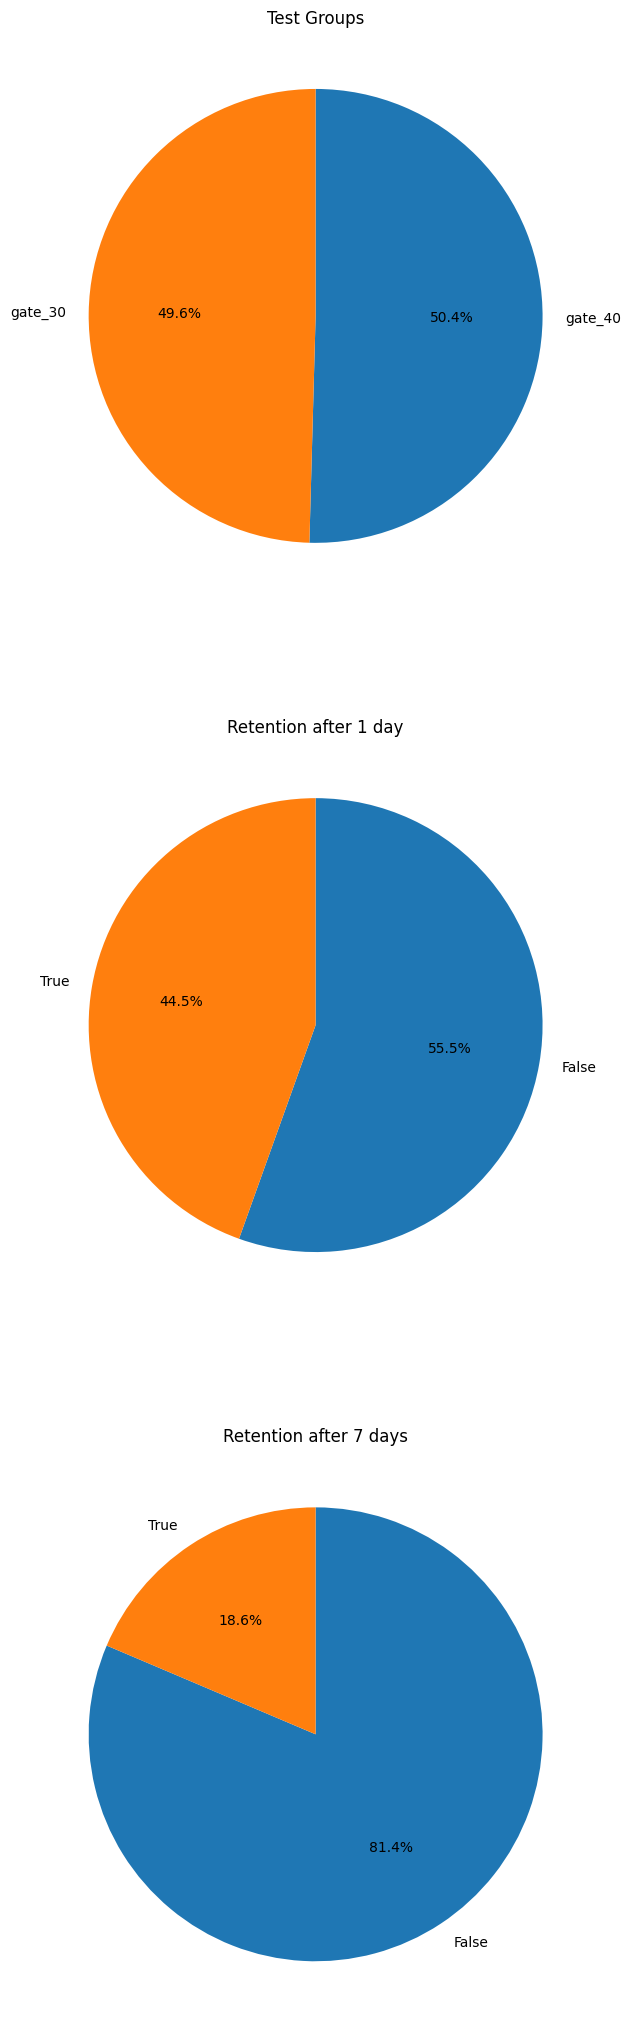

In [19]:
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as patheffects

fig = plt.figure(figsize=(12, 35))
gs = GridSpec(4, 1, figure=fig, hspace=0.25) 

# Color palettes for each variable
version_colors = ['#4e79a7', '#f28e2b']
retention_colors = ['#52327a', '#f3840a']

# Function to add value and percentage labels on bars
def add_value_labels_with_percent(ax, total_count, rotate_percentages=False, text_color='black', font_size=10):
    """  
   Add value and percentage labels on bars in a matplotlib axis.  
  
   Parameters:  
   ax (matplotlib.axes.Axes): The axis to add labels to.  
   total_count (int): The total count used to calculate percentages.  
   rotate_percentages (bool, optional): Whether to rotate percentage labels by 90 degrees. Defaults to False.  
   """      
    if total_count == 0:
        raise ValueError("Total count must be greater than zero.")
    
    for patch in ax.patches:
        height = patch.get_height()
        # Add value label
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2., height), 
                    ha='center', va='bottom', color=text_color, fontsize=font_size)
        
        # Calculate and add percentage label
        percentage = 100 * height / total_count
        ax.annotate(f'{percentage:.1f}%', 
                    (patch.get_x() + patch.get_width() / 2., height / 2),
                    ha='center', va='center', color='white', fontweight='bold', fontsize=font_size,
                    rotation=90 if rotate_percentages else 0,
                    path_effects=[patheffects.withStroke(linewidth=1, foreground='black')])

# Plot 1: 'version'
ax1 = fig.add_subplot(gs[0, 0])
test_group_counts = data['version'].value_counts()
pie_plot_1 = test_group_counts.plot(kind='pie', ax=ax1, color=version_colors, 
                                    autopct='%1.1f%%', startangle=90, counterclock=False)
ax1.set_title('Test Groups')
ax1.set_ylabel('')  # Remove y-label for pie chart

# Plot 2: 'retention_1'
ax2 = fig.add_subplot(gs[1, 0])
reten_1_counts = data['retention_1'].value_counts()
pie_plot_2 = reten_1_counts.plot(kind='pie', ax=ax2, color=retention_colors,
                                   autopct='%1.1f%%', startangle=90, counterclock=False)
ax2.set_title('Retention after 1 day')
ax2.set_xlabel('')
ax2.set_ylabel('')  # Remove y-label for pie chart

# Plot 2: 'retention_2'
ax3 = fig.add_subplot(gs[2, 0])
reten_7_counts = data['retention_7'].value_counts()
pie_plot_3 = reten_7_counts.plot(kind='pie', ax=ax3, color=retention_colors,
                                   autopct='%1.1f%%', startangle=90, counterclock=False)
ax3.set_title('Retention after 7 days')
ax3.set_xlabel('')
ax3.set_ylabel('')  # Remove y-label for pie chart

**Summary**:

- **Test Groups**: This plot shows the number of users who began the game at gate 30 versus those who began at gate 40. There were slightly more gamers at the gate 30 (50.4%). This difference is insignificant and the distribution looks balanced with no fear of skewing
- **Retention_1**: This variable indicates whether users played the game after the first day of downloading. The majority of gamers (55.5%) stopped playing after the first day.
- **Retention_7**: This variable indicates whether users played the game after the seventh day of downloading. The majority of gamers (81.4%) stopped playing after the first day.

### Numerical Variable: sum_gamerounds

Next, we analyze the numerical variable `sum_gamerounds` to understand how many rounds users played after downloading and to explore the distribution of this variable.

In [20]:
# Calculate summary statistics for 'total ads'
data['sum_gamerounds'].describe().round(2)

count    90189.00
mean        51.87
std        195.05
min          0.00
25%          5.00
50%         16.00
75%         51.00
max      49854.00
Name: sum_gamerounds, dtype: float64

In the summary statistics table above, notice that percentiles highlights the presence of significant outliers. Thus, before plotting the histogram, we filter out the extreme outliers (above the 95th percentile) to focus on the majority of users. This helps us create a clearer and more interpretable histogram, as the extreme values can distort our understanding of the overall distribution.

In [21]:
# To identify outliers for sum_gamerounds

# Calculate Z-scores
data['z_score'] = np.abs(stats.zscore(data['sum_gamerounds']))

# Identify outliers
outliers = data[(data['z_score'] > 3) | (data['z_score'] < -3)]

In [22]:
outliers["sum_gamerounds"].describe().round(2)

count      425.00
mean      1035.19
std       2396.13
min        638.00
25%        707.00
50%        812.00
75%       1026.00
max      49854.00
Name: sum_gamerounds, dtype: float64

In [23]:
# Drop outliers
data_clean = data[~((data['z_score'] > 3) | (data['z_score'] < -3))]

# Drop the z_score column as it's no longer needed
data_clean = data_clean.drop(columns=['z_score'])

print(data_clean.head())

   version  sum_gamerounds  retention_1  retention_7
0  gate_30               3        False        False
1  gate_30              38         True        False
2  gate_40             165         True        False
3  gate_40               1        False        False
4  gate_40             179         True         True


In [24]:
data_clean['sum_gamerounds'].describe().round(2)

count    89764.00
mean        47.22
std         80.66
min          0.00
25%          5.00
50%         16.00
75%         50.00
max        637.00
Name: sum_gamerounds, dtype: float64

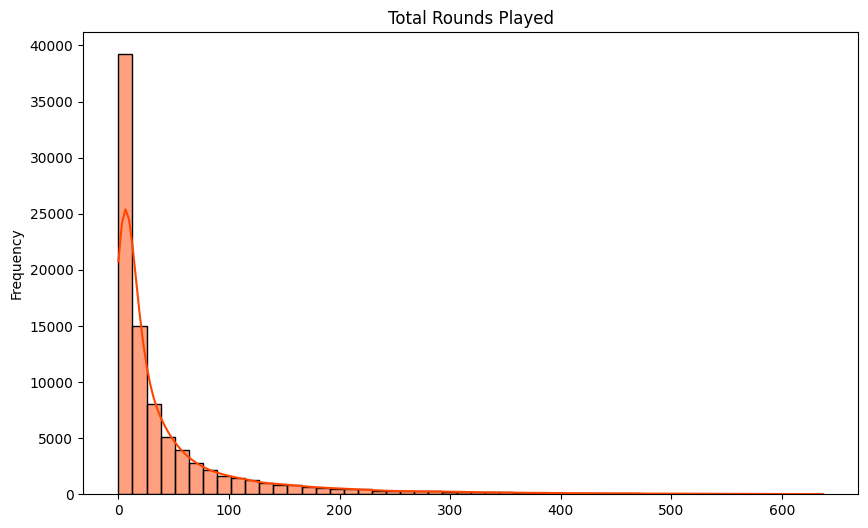

In [25]:
# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data_clean['sum_gamerounds'], bins=50, kde=True, color='orangered')
plt.title('Total Rounds Played')
plt.xlabel('')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Calculate the histogram
counts, bin_edges = np.histogram(data_clean['sum_gamerounds'], bins=50)

# Calculate the range
data_range = bin_edges[-1] - bin_edges[0]
print("Range of the histogram:", data_range)

Range of the histogram: 637.0


**Summary**:
- **Average Rounds Viewed**: On average, users played around 25 rounds.
- **Distribution**: The data is right-skewed, indicating that while most users played a relatively small number of rounds, a few were played significantly more.
- **Outliers**: The range extends up to 637 rounds, highlighting the presence of significant outliers, although most users played fewer than 100 rounds.
- **Histogram**: The histogram illustrates that most users played a small number of rounds, with the majority clustered at the lower end of the distribution. The KDE curve further emphasizes this skewness.

## Bivariate Analysis

---

Having examined the distribution of individual variables, we now move on to bivariate analysis. In this section, we explore the relationships between pairs of variables to uncover potential patterns and insights. This involves visualizing how different variables interact with each other, which can help us identify trends and areas for deeper analysis. Specifically, we will look at:
1. **versions vs. retention_1**: Whether users who played the game at different gates played after the first day after download.
2. **versions vs. retention_7**: Whether users who played the game at different gates played after the seventh day after download.
3. **versions vs sum_gamerounds**: Whether users who played the game at different gates played more rounds
4. **sum_gamerounds vs. retention_1**: How the number of rounds played relates to whether a user continued playing after the first day after download.
5. **sum_gamerounds vs. retention_7**: How the number of rounds played relates to whether a user continued playing after the first day after download

### 1. versions vs. retention_1
---
To understand the effectiveness of the gates, we first examine the relationship between the `version` (whether a user started at `game_30` or `game_40`) and the `retention_1` (whether the user continued playing after day 1).
> 
> This key metric is vital for evaluating the effectiveness of the gate and understanding whether the gate influenced user behavior.

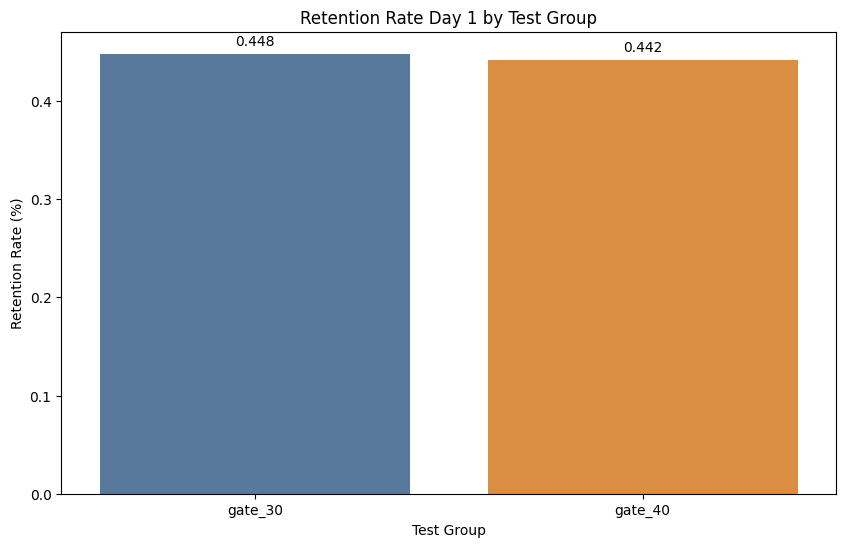

In [27]:
# Plot: versions vs. retention_1
plt.figure(figsize=(10, 6))
import seaborn as sns
barplot= sns.barplot(data=data, x='version', y='retention_1', hue='version', palette=['#4e79a7', '#f28e2b'], errorbar=None, legend=False)

# Add values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.3f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
    
plt.title('Retention Rate Day 1 by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Retention Rate (%)')
plt.show()

In [ ]:
Data Collection: Track user behavior and engagement metrics for both groups over a specified period.

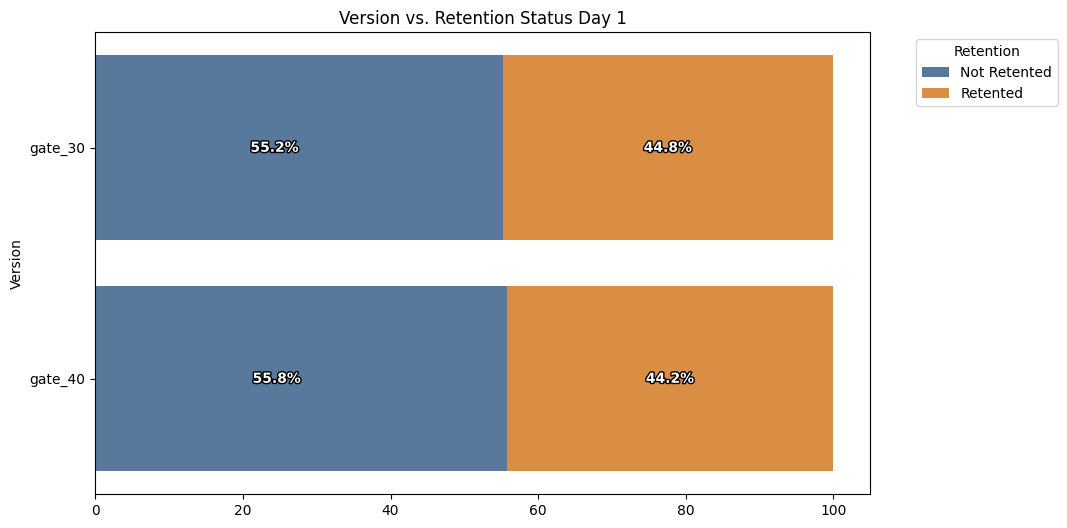

In [29]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Group the retention status by day and fill missing values with 0
reten_1_counts = data.groupby(['version', 'retention_1']).size().unstack().fillna(0)

# Calculate the percentage of retention after day 1
retention_percentages = reten_1_counts.div(reten_1_counts.sum(axis=1), axis=0) * 100

# Plot the retention percentages
sns.barplot(x=retention_percentages[False], y=retention_percentages.index, color='#4e79a7', label='Not Retented')
sns.barplot(x=retention_percentages[True], y=retention_percentages.index, color='#f28e2b', label='Retented', left=retention_percentages[False])

# Add percentage labels to the bars
for i in range(retention_percentages.shape[0]):
    # Add label for 'Not Retented'
    plt.text(retention_percentages[False].iloc[i] / 2, i, 
             f'{retention_percentages[False].iloc[i]:.1f}%', 
             ha='right', va='center', color='white', fontweight='bold', 
             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

    # Add label for 'Retented'
    plt.text(retention_percentages[False].iloc[i] + retention_percentages[True].iloc[i] / 2, i, 
             f'{retention_percentages[True].iloc[i]:.1f}%', 
             ha='center', va='center', color='white', fontweight='bold', 
             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

# Set plot title and labels
plt.title('Version vs. Retention Status Day 1')
plt.xlabel('')
plt.ylabel('Version')
plt.legend(title='Retention', bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Show the plot
plt.show()

**Summary**:

The bar plot below displays the retentions for each group. The 'gate_30' group had a conversion rate of 44.8%, while the 'gate_40' group had a retention rate of 44.2%. While this difference suggests that the difference in gates look relatively low. Further analysis in the *Statistical Testing* will help us determine whether the difference is significant enough.

### 2. versions vs. retention_7
---

We then examine the relationship between the versions and whether they continued to play after 7 days (Retention Status). This analysis helps us understand if gates are more effective in driving retention.

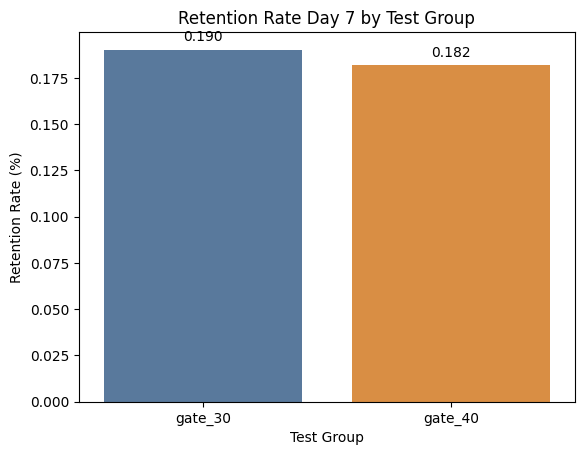

In [28]:
barplot_1= sns.barplot(data=data, x='version', y='retention_7', hue='version', palette=['#4e79a7', '#f28e2b'], errorbar=None, legend=False)

# Add values on top of the bars
for p in barplot_1.patches:
    barplot_1.annotate(format(p.get_height(), '.3f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
    
plt.title('Retention Rate Day 7 by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Retention Rate (%)')
plt.show()

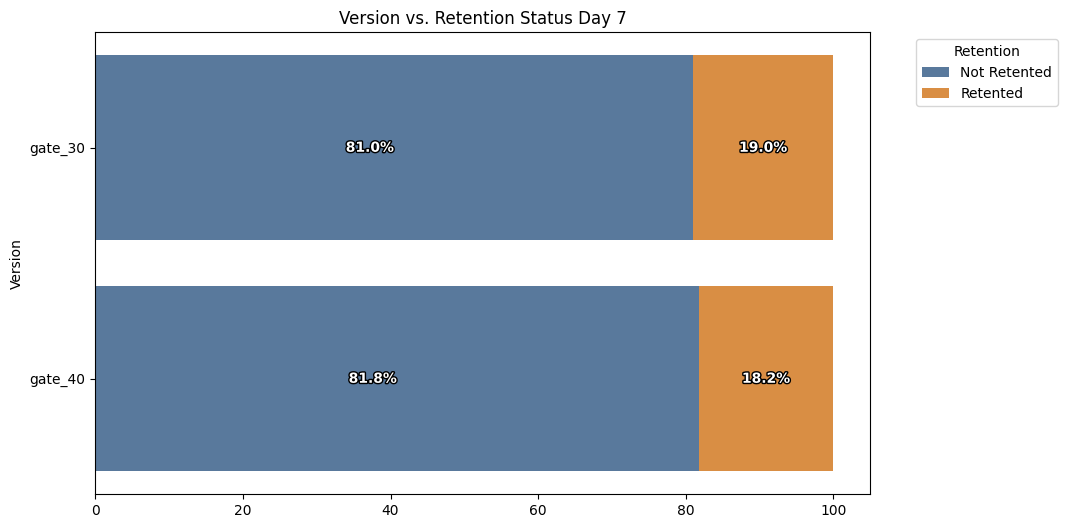

In [30]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Group the retention status by day and fill missing values with 0
reten_7_counts = data.groupby(['version', 'retention_7']).size().unstack().fillna(0)

# Calculate the percentage of retention after day 7
retention_percentages = reten_7_counts.div(reten_7_counts.sum(axis=1), axis=0) * 100

# Plot the retention percentages
sns.barplot(x=retention_percentages[False], y=retention_percentages.index, color='#4e79a7', label='Not Retented')
sns.barplot(x=retention_percentages[True], y=retention_percentages.index, color='#f28e2b', label='Retented', left=retention_percentages[False])

# Add percentage labels to the bars
for i in range(retention_percentages.shape[0]):
    # Add label for 'Not Retented'
    plt.text(retention_percentages[False].iloc[i] / 2, i, 
             f'{retention_percentages[False].iloc[i]:.1f}%', 
             ha='right', va='center', color='white', fontweight='bold', 
             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

    # Add label for 'Retented'
    plt.text(retention_percentages[False].iloc[i] + retention_percentages[True].iloc[i] / 2, i, 
             f'{retention_percentages[True].iloc[i]:.1f}%', 
             ha='center', va='center', color='white', fontweight='bold', 
             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

# Set plot title and labels
plt.title('Version vs. Retention Status Day 7')
plt.xlabel('')
plt.ylabel('Version')
plt.legend(title='Retention', bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Show the plot
plt.show()

**Summary**:

The bar plot above displays the retentions for each group after the seventh day. The 'gate_30' group had a conversion rate of 19.0%, while the 'gate_40' group had a retention rate of 18.2%. While this difference suggests that the difference in gates look relatively low. Further analysis in the *Statistical Testing* will help us determine whether the difference is significant enough.

### 3. versions vs sum_gamerounds
---

Next, we visualize the relationship between the version and the total number of game rounds player by a user (`sum_gameounds`). This helps us understand if higher gamerounds exposure correlates with higher gates.

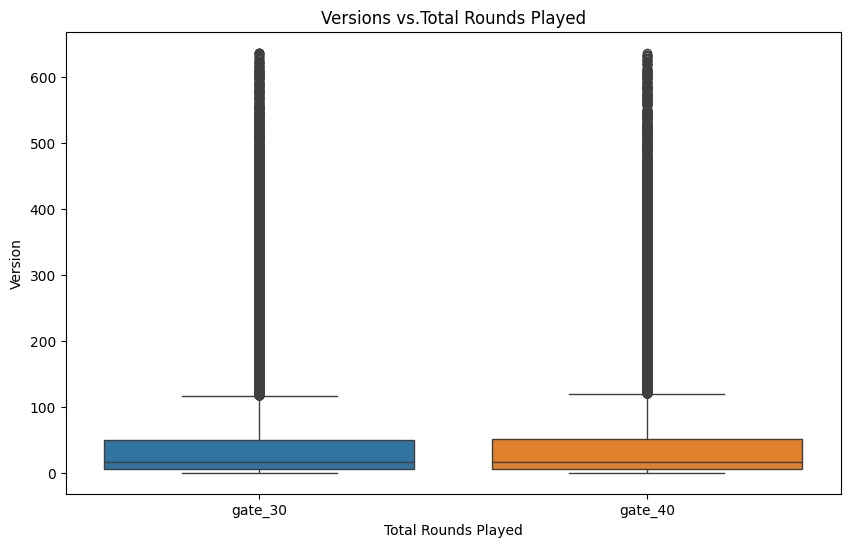

In [31]:
# Plot: Total Ads vs. Converted
plt.figure(figsize=(10, 6))

# Create a box plot for Total Ads vs. Converted after filtering extreme values
sns.boxplot(data=data_clean, x='version', y='sum_gamerounds', hue = 'version', legend = False)
plt.title('Versions vs.Total Rounds Played')
plt.xlabel('Total Rounds Played')
plt.ylabel('Version')
plt.show()

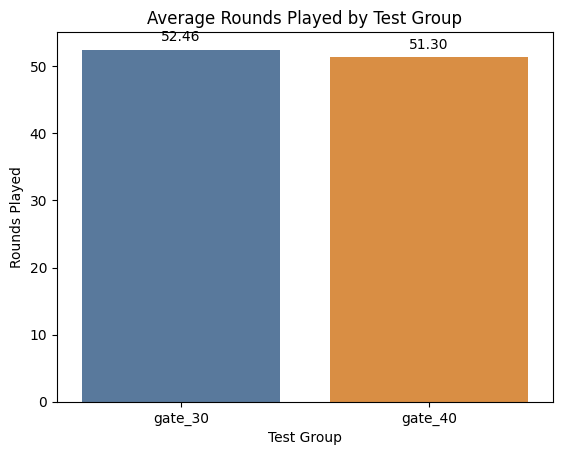

In [33]:
barplot_3= sns.barplot(data=data, x='version', y='sum_gamerounds', hue='version', estimator=np.mean, palette=['#4e79a7', '#f28e2b'], errorbar=None, legend=False)

# Add values on top of the bars
for p in barplot_3.patches:
    barplot_3.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
    
plt.title('Average Rounds Played by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Rounds Played')
plt.show()

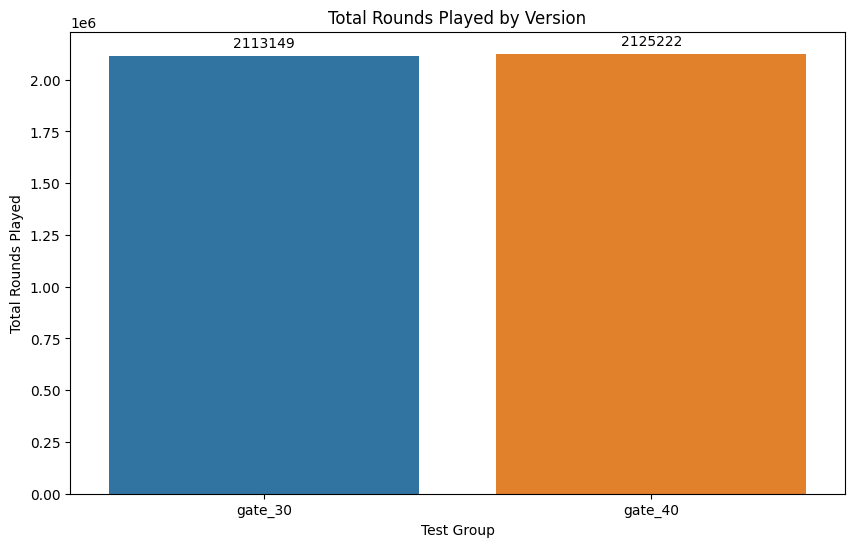

In [87]:
plt.figure(figsize=(10, 6))
barplot_3 = sns.barplot(data=data_clean, x='version', y='sum_gamerounds', estimator=np.sum, hue='version', legend = False, errorbar=None)

# Add values on top of the bars
for p in barplot_3.patches:
    barplot_3.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 9), 
                       textcoords='offset points')

plt.title('Total Rounds Played by Version')
plt.xlabel('Test Group')
plt.ylabel('Total Rounds Played')
plt.show()

**Summary**:

The box plot shows the distribution of total rounds played for users by version.
- Users who have played at gate_40 played a slightly higher number of rounds compared to gate_30 players.
- However, users played more rounds at the averag at gate_30 compared to gate_40 players

### 4. sum_gamerounds vs. retention_1
---

Next, we visualize the relationship between the total number of game rounds player by a user (`sum_gameounds`) and whether they retended (retention status) after day 1. This helps us understand if higher gamerounds exposure correlates with higher retention rates.

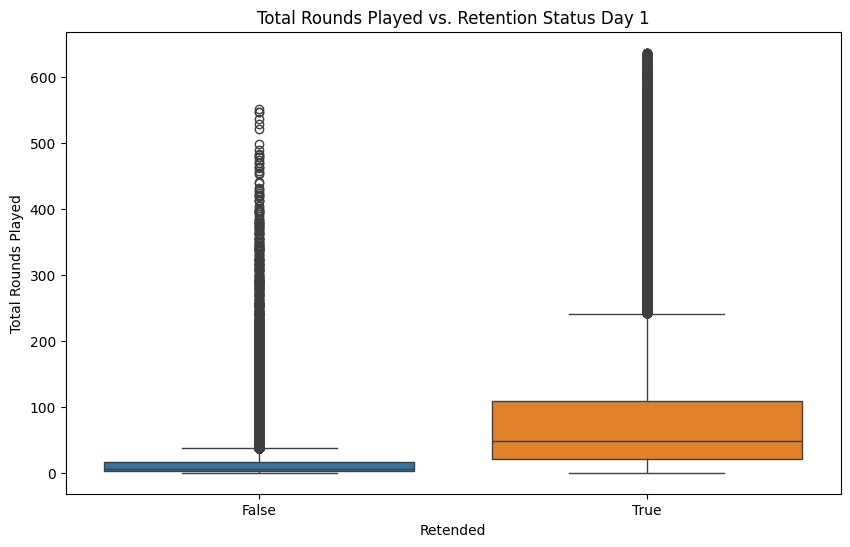

In [34]:
# Plot: Total Ads vs. Converted
plt.figure(figsize=(10, 6))

# Create a box plot for Total Ads vs. Converted after filtering extreme values
sns.boxplot(data=data_clean, x='retention_1', y='sum_gamerounds', hue = 'retention_1', legend = False)
plt.title('Total Rounds Played vs. Retention Status Day 1')
plt.xlabel('Retended')
plt.ylabel('Total Rounds Played')
plt.show()

**Summary**:

The box plot shows the distribution of total rounds played for users who retended (True) versus those who did not (False).
- Users who have played a higher number of rounds tend to continue playing after day 1, as indicated by the median and the interquartile range (IQR) being noticeably higher compared to non-retended users.
- The spread of total rounds viewed among non-retended users is wider, suggesting more variability in engagement levels.
- Despite the differences, there is still considerable overlap between the two groups, indicating that while playing more rounds might contribute to retention, it may not be the sole determining factor.

### 5. sum_gamerounds vs. retention_7
---

Finally, we visualize the relationship between the total number of game rounds player by a user (`sum_gameounds`) and whether they retended (retention status) after day 7. This helps us understand if higher gamerounds exposure correlates with higher retention rates.

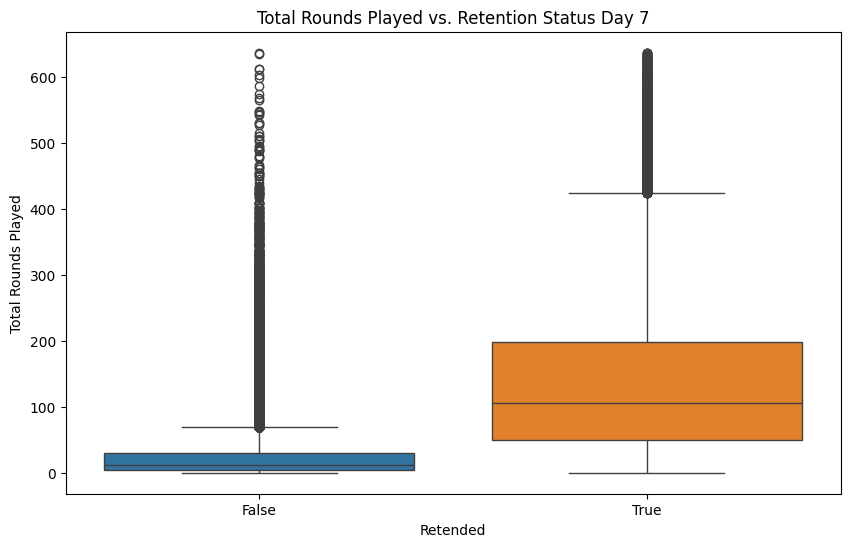

In [36]:
# Plot: Total Ads vs. Converted
plt.figure(figsize=(10, 6))

# Create a box plot for Total Ads vs. Converted after filtering extreme values
sns.boxplot(data=data_clean, x='retention_7', y='sum_gamerounds', hue = 'retention_7', legend = False)
plt.title('Total Rounds Played vs. Retention Status Day 7')
plt.xlabel('Retended')
plt.ylabel('Total Rounds Played')
plt.show()

**Summary**:

The box plot shows the distribution of total rounds played for users who retended (True) versus those who did not (False).
- Users who have played a higher number of rounds tend to continue playing after day 7, as indicated by the median and the interquartile range (IQR) being noticeably higher compared to non-retended users.
- The spread of total rounds viewed among non-retended users is wider, suggesting more variability in engagement levels.
- Despite the differences, there is still considerable overlap between the two groups, indicating that while playing more rounds might contribute to retention, it may not be the sole determining factor.

## Statistical Testing

---

### Assessing the Impact of Gates on Retention

In this section, we conduct hypothesis testing to determine whether the differences in retention between users exposed to gate_30 and those of gate_40 are statistically significant.  Given the balance in sample sizes and the nature of the data, both parametric and non-parametric tests are employed to ensure robust findings.

**Hypotheses**:
1.  - **Null Hypothesis (H₀)**: There is no difference in the retention rates between the 'gate_30' and 'gate_40' groups after day 1. Any observed difference is due to random chance.
    - **Alternative Hypothesis (H₁)**: There is a difference in the retention rates between 'gate_30' and 'gate_40' groups after day 1, suggesting that the gates has an effect on conversions.

2.  - **Null Hypothesis (H₀)**: There is no difference in the retention rates between the 'gate_30' and 'gate_40' groups after day 7. Any observed difference is due to random chance.
    - **Alternative Hypothesis (H₁)**: There is a difference in the retention rates between 'gate_30' and 'gate_40' groups after day 7, suggesting that the gates has an effect on conversions.

3.   - **Null Hypothesis (H₀)**: There is no difference in the sum of game rounds between the 'gate_30' and 'gate_40' groups. Any observed difference is due to random chance.
     - **Alternative Hypothesis (H₁)**: There is a difference in the sum of game rounds between 'gate_30' and 'gate_40' groups, suggesting that the gates has an effect on game rounds played.


Given the binary nature of the conversion data (retended or not retended), we can consider two approaches:

1. **Chi-Square Test of Independence**: This test is appropriate for categorical data and can be used to assess whether the distribution of conversion status (retended or not) is independent of the test group (gate_30 or gate_40).
The test will help us determine if the differences in retention rates are statistically significant.
2. **Mann-Whitney U Test**: The Mann-Whitney U test (also known as the Wilcoxon Rank-Sum Test), a non-parametric alternative to the t-test, can be used to compare the ranks of retention between the 'gate_30' and 'gate_40' groups.

#### version and retetntion_1
---

To begin our analysis, we create a contingency table that summarizes the relationship between `version` and `retention_1`. This table will help us understand the frequency distribution of retention across test groups.

In [37]:
# Create a contingency table
contingency_table_group_1 = pd.crosstab(data['version'], data['retention_1'])
contingency_table_group_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


Next, we check the expected frequencies to ensure that the assumptions for the Chi-Square test are satisfied.

In [38]:
def perform_chi_square_test(contingency_table):
    # Perform the Chi-Square Test
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)
    
    # Convert the expected frequencies to a DataFrame for easier manipulation
    expected_frequencies = pd.DataFrame(ex, index=contingency_table.index, columns=contingency_table.columns)
    
    # Check if all expected frequencies are 5 or more
    min_expected_frequency = expected_frequencies.min().min()
    
    if min_expected_frequency < 5:
        print("Warning: Some expected frequencies are less than 5. The Chi-Square test may not be valid.")
    else:
        print("All expected frequencies are 5 or more. The Chi-Square test is valid.")
    
    # Output the Chi-Square statistic, p-value, degrees of freedom, and expected frequencies
    print(f"\nChi-Square Statistic: {chi2_stat}")
    print(f"P-Value: {p_val}")
    print(f"Degrees of Freedom: {dof}")
    print("\nExpected Frequencies:")
    print(expected_frequencies.round(2))

In [39]:
perform_chi_square_test(contingency_table_group_1)

All expected frequencies are 5 or more. The Chi-Square test is valid.

Chi-Square Statistic: 3.1591007878782262
P-Value: 0.07550476210309086
Degrees of Freedom: 1

Expected Frequencies:
retention_1     False     True 
version                        
gate_30      24799.14  19900.86
gate_40      25236.86  20252.14


Since the expected frequencies are all above 5, the assumptions for the Chi-Square test are satisfied. Now, we can perform the Chi-Square test to determine if there is a statistically significant relationship between `version` and `retention_1`.

In [40]:
# Perform the Chi-Square Test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table_group_1)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat.round(2)}")
print(f"P-Value: {p_val.round(4)}")
print(f"Degrees of Freedom: {dof}")

# Interpretation of the p-value
alpha = 0.05
if p_val < alpha:
    print("The p-value is less than 0.05, indicating a significant relationship between 'version' and 'retention_1'.")
else:
    print("The p-value is greater than 0.05, indicating no significant relationship between 'version' and 'retention_1'.")

Chi-Square Statistic: 3.16
P-Value: 0.0755
Degrees of Freedom: 1
The p-value is greater than 0.05, indicating no significant relationship between 'version' and 'retention_1'.


The Chi-Square test indicates no statistically significant relationship between the versions and retention status after day 1. The Mann-Whitney U test is employed next.

In [77]:
from scipy.stats import mannwhitneyu

# Separate the data into two groups: ad and psa
gate_30_group = data[data['version'] == 'gate_30']['retention_1']
gate_40_group = data[data['version'] == 'gate_40']['retention_1']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(gate_30_group, gate_40_group)

# Define significance level
alpha = 0.05

# Print the results
print(f"Mann-Whitney U Statistic: {stat.round(2)}")
print(f"P-Value: {p_value.round(4)}")

# Check if the result is significant
if p_value < alpha:
    print("The result is statistically significant.")
    print("Reject the null hypothesis: There is a significant difference between the gate_30 and gate_40 groups.")
else:
    print("The result is not statistically significant.")
    print("Fail to reject the null hypothesis: There is no significant difference between the gate_30 and gate_40 groups.")

Mann-Whitney U Statistic: 1022682813.0
P-Value: 0.0744
The result is not statistically significant.
Fail to reject the null hypothesis: There is no significant difference between the gate_30 and gate_40 groups.


<span style="font-size: 16px;">The Mann-Whitney U test confirms that there is no statistically significant difference between the retention rates of the 'gate_30' and 'game_40' groups after day 1. This supports the idea that the gates themselves do not potentially contribute to the success of the campaign after day 1.</span>

In [42]:
# To visualize the relationship between `version` and `retention_1`, we create a heatmap of the contingency table:

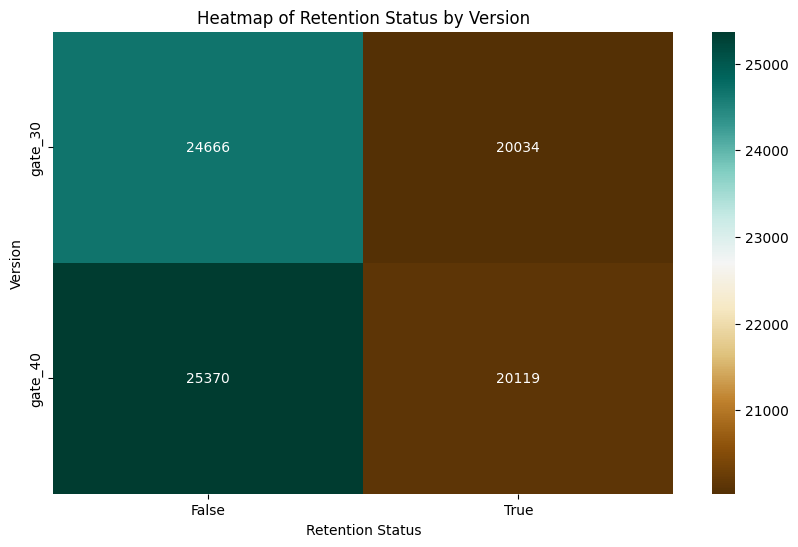

In [43]:
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table_group_1, annot=True, cmap="BrBG", fmt='d')
plt.title('Heatmap of Retention Status by Version')
plt.xlabel('Retention Status')
plt.ylabel('Version')
plt.show()

Next, we calculate the retention rates for each version.

In [44]:
# Calculate retention rates for each version at day 1
reten_rates_day_1 = contingency_table_group_1.div(contingency_table_group_1.sum(axis=1), axis=0) * 100

# Display conversion rates
print("Retention Rates by Day 1:")
print(reten_rates_day_1[True].round(1).sort_values(ascending=False))

Retention Rates by Day 1:
version
gate_30    44.8
gate_40    44.2
Name: True, dtype: float64


**Conclusion:**

Given no statistical significance, it suggests that gates differences plays no significant role in influencing retention rates after day 1.

#### version and retetntion_7
---

To begin our analysis, we create a contingency table that summarizes the relationship between `version` and `retention_7`. This table will help us understand the frequency distribution of retention across test groups.

In [45]:
# Create a contingency table
contingency_table_group_7 = pd.crosstab(data['version'], data['retention_7'])
contingency_table_group_7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


Next, we check the expected frequencies to ensure that the assumptions for the Chi-Square test are satisfied.

In [46]:
perform_chi_square_test(contingency_table_group_7)

All expected frequencies are 5 or more. The Chi-Square test is valid.

Chi-Square Statistic: 9.959086799559167
P-Value: 0.0016005742679058301
Degrees of Freedom: 1

Expected Frequencies:
retention_7    False   True 
version                     
gate_30      36382.9  8317.1
gate_40      37025.1  8463.9


Since the expected frequencies are all above 5, the assumptions for the Chi-Square test are satisfied. Now, we can perform the Chi-Square test to determine if there is a statistically significant relationship between `version` and `retention_7`.

In [47]:
# Perform the Chi-Square Test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table_group_7)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat.round(2)}")
print(f"P-Value: {p_val.round(4)}")
print(f"Degrees of Freedom: {dof}")

# Interpretation of the p-value
alpha = 0.05
if p_val < alpha:
    print("The p-value is less than 0.05, indicating a significant relationship between 'version' and 'retention_7'.")
else:
    print("The p-value is greater than 0.05, indicating no significant relationship between 'version' and 'retention_7'.")

Chi-Square Statistic: 9.96
P-Value: 0.0016
Degrees of Freedom: 1
The p-value is less than 0.05, indicating a significant relationship between 'version' and 'retention_7'.


The Chi-Square test indicates a statistically significant relationship between the versions and retention status after day 7. The Mann-Whitney U test is employed next.

In [48]:
from scipy.stats import mannwhitneyu

# Separate the data into two groups: ad and psa
gate_30_group_7 = data[data['version'] == 'gate_30']['retention_7']
gate_40_group_7 = data[data['version'] == 'gate_40']['retention_7']

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(gate_30_group_7, gate_40_group_7)

# Define significance level
alpha = 0.05

# Print the results
print(f"Mann-Whitney U Statistic: {stat.round(2)}")
print(f"P-Value: {p_value.round(4)}")

# Check if the result is significant
if p_value < alpha:
    print("The result is statistically significant.")
    print("Reject the null hypothesis: There is a significant difference between the gate_30 and gate_40 groups after the seventh day.")
else:
    print("The result is not statistically significant.")
    print("Fail to reject the null hypothesis: There is no significant difference between the gate_30 and gate_40 groups after the seventh day.")

Mann-Whitney U Statistic: 1025017239.0
P-Value: 0.0016
The result is statistically significant.
Reject the null hypothesis: There is a significant difference between the gate_30 and gate_40 groups after the seventh day.


The Mann-Whitney U test confirms that there is a statistically significant difference between the retention rates of the 'gate_30' and 'game_40' groups after day 7. This supports the idea that the gates themselves potentially contribute to the success of the campaign after the seventh day

To visualize the relationship between `version` and `retention_7`, we create a heatmap of the contingency table:

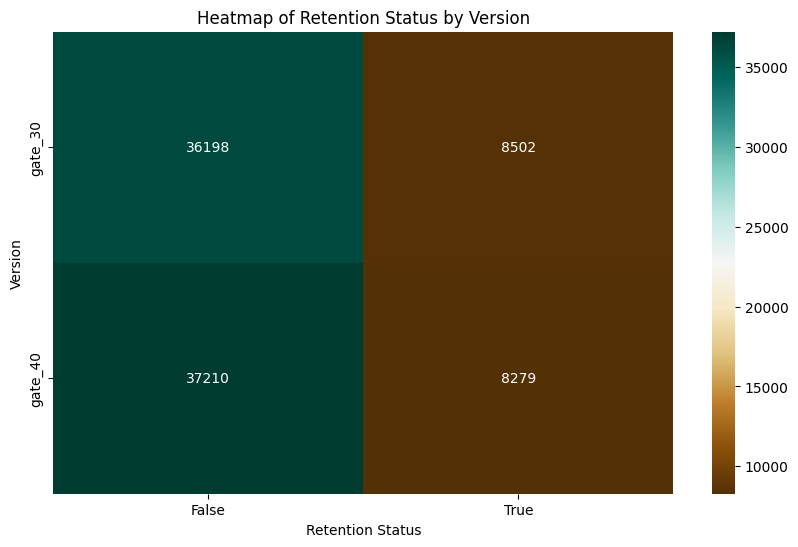

In [49]:
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table_group_7, annot=True, cmap="BrBG", fmt='d')
plt.title('Heatmap of Retention Status by Version')
plt.xlabel('Retention Status')
plt.ylabel('Version')
plt.show()

Next, we calculate the retention rates for each version.

In [50]:
# Calculate retention rates for each version at day 1
reten_rates_day_7 = contingency_table_group_7.div(contingency_table_group_7.sum(axis=1), axis=0) * 100

# Display conversion rates
print("Retention Rates by Day 7:")
print(reten_rates_day_7[True].round(1).sort_values(ascending=False))

Retention Rates by Day 7:
version
gate_30    19.0
gate_40    18.2
Name: True, dtype: float64


**Conclusion:**

There is a statistically significant relationship between `version` and `retention_7`. This suggests that the version of the game does influence the likelihood of retention after the seventh day.

#### version and sum_gamerounds

To begin our analysis, we create a contingency table that summarizes the relationship between `version` and `sum_gamerounds`. This 
table will help us understand the frequency distribution of game rounds played across test groups.

In [51]:
# Generate bins for sum_gamerounds

max_value = data_clean['sum_gamerounds'].max()
bins = range(0, max_value + 10, 90)  # Adjust the step size as needed

# Create bins
data_clean['gamerounds_bin'] = pd.cut(data_clean['sum_gamerounds'], bins=bins, right=False)

In [52]:
data_clean.head()

,version,sum_gamerounds,retention_1,retention_7,gamerounds_bin
0,gate_30,3,False,False,"[0, 90)"
1,gate_30,38,True,False,"[0, 90)"
2,gate_40,165,True,False,"[90, 180)"
3,gate_40,1,False,False,"[0, 90)"
4,gate_40,179,True,True,"[90, 180)"


In [53]:
data_clean['gamerounds_bin'].value_counts()

gamerounds_bin
[0, 90)       76281
[90, 180)      7749
[180, 270)     2871
[270, 360)     1438
[360, 450)      720
[450, 540)      427
[540, 630)      264
Name: count, dtype: int64

In [54]:
contigency_table_round = pd.crosstab(data_clean.version, data_clean.gamerounds_bin)
contigency_table_round

gamerounds_bin,"[0, 90)","[90, 180)","[180, 270)","[270, 360)","[360, 450)","[450, 540)","[540, 630)"
version,,,,,,,
gate_30,37879,3725,1447,719,366,216,140
gate_40,38402,4024,1424,719,354,211,124


Next, we check the expected frequencies to ensure that the assumptions for the Chi-Square test are satisfied.

In [55]:
perform_chi_square_test(contigency_table_round)

All expected frequencies are 5 or more. The Chi-Square test is valid.

Chi-Square Statistic: 9.998467644938767
P-Value: 0.12471656511237726
Degrees of Freedom: 6

Expected Frequencies:
gamerounds_bin   [0, 90)  [90, 180)  [180, 270)  [270, 360)  [360, 450)  \
version                                                                   
gate_30         37814.98    3841.43     1423.25      712.86      356.93   
gate_40         38466.02    3907.57     1447.75      725.14      363.07   

gamerounds_bin  [450, 540)  [540, 630)  
version                                 
gate_30             211.68      130.87  
gate_40             215.32      133.13  


Since the expected frequencies are all above 5, the assumptions for the Chi-Square test are satisfied. Now, we can perform the Chi-Square test to determine if there is a statistically significant relationship between `version` and `sum_gamerounds`.

In [56]:
# Perform the Chi-Square Test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contigency_table_round)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")
print(f"Degrees of Freedom: {dof}")

# Interpretation of the p-value
alpha = 0.05
if p_val < alpha:
    print("The p-value is less than 0.05, indicating a significant relationship between 'version' and 'sum_gamerounds'.")
else:
    print("The p-value is greater than 0.05, indicating no significant relationship between 'version' and 'sum_gamerounds'.")

Chi-Square Statistic: 9.998467644938767
P-Value: 0.12471656511237726
Degrees of Freedom: 6
The p-value is greater than 0.05, indicating no significant relationship between 'version' and 'sum_gamerounds'.


The Chi-Square test indicates no statistically significant relationship between the versions and sum of the game rounds played. The Kruskal Wallis test is better suited for categorical data.

In [57]:
from scipy.stats import kruskal

# Separate the data into groups based on version
groups = [data_clean[data_clean['version'] == version]['gamerounds_bin'] for version in data_clean['version'].unique()]

# Perform the Kruskal-Wallis test
def kruskal_wallis_test(groups, alpha=0.05):
    stat, p = kruskal(*groups)
    if p < alpha:
        return "Reject the null hypothesis: There is a significant difference between the groups."
    else:
        return "Fail to reject the null hypothesis: There is no significant difference between the groups."

result = kruskal_wallis_test(groups)
print(result)

Fail to reject the null hypothesis: There is no significant difference between the groups.


The Kruskal Wallis test confirms that there is no statistically significant difference between the sum of game rounds played by 'gate_30' and 'game_40' groups. This supports the idea that the gates do not themselves potentially contribute to the success of the campaign.

To visualize the relationship between `version` and `sum_gamerounds`, we create a heatmap of the contingency table:

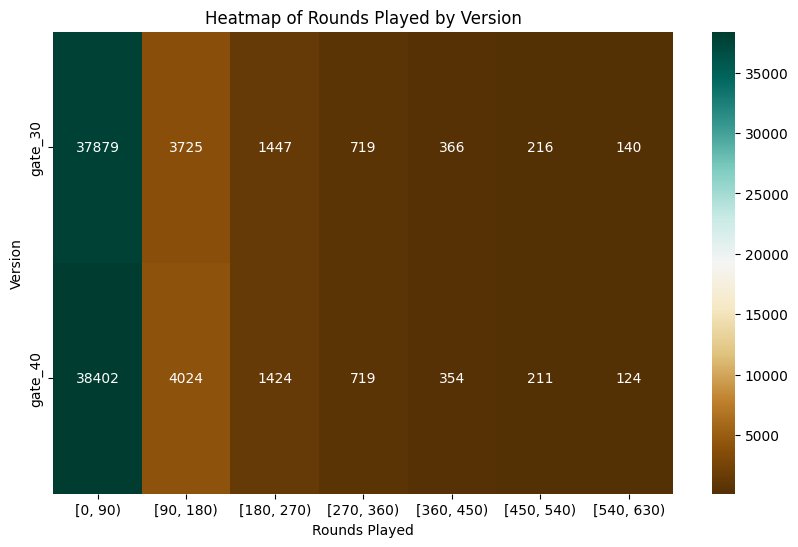

In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(contigency_table_round, annot=True, cmap="BrBG", fmt='d')
plt.title('Heatmap of Rounds Played by Version')
plt.xlabel('Rounds Played')
plt.ylabel('Version')
plt.show()

Next, we calculate the retention rates for each version.

In [60]:
# Calculate rounds played rates for each version
rounds_played = contigency_table_round.div(contigency_table_round.sum(axis=1), axis=0) * 100

# Display conversion rates
print("Rounds played rates:")
print(rounds_played.round(1).sort_values(by=rounds_played.columns[0], ascending=False).T)

Rounds played rates:
version         gate_30  gate_40
gamerounds_bin                  
[0, 90)            85.1     84.9
[90, 180)           8.4      8.9
[180, 270)          3.3      3.1
[270, 360)          1.6      1.6
[360, 450)          0.8      0.8
[450, 540)          0.5      0.5
[540, 630)          0.3      0.3


### Analyzing Rounds Played and Retention Success
---

In this section, we analyze the relationship between the total number of rounds played by users and their likelihood of playing after day 7. 

In our analysis, we aim to determine if there is a statistically significant relationship between the total number of rounds played and the retention rate. Specifically, we want to explore:

- Does viewing playing more game rounds increase the likelihood of a user retending after 7 days?
- Is there an optimal number of rounds that maximizes retention rates?

By analyzing the relationship between game rounds played and retention rates, we aim to:
- Identify the most effective ad strategies: Determine whether to increase targeted ads towards players who play certain rounds.
- Optimize the difficulty of rounds: Find the optimal number of rounds that maximizes retention rates while avoiding potential disinterest, where users might become less responsive to play after losing too many times.

To begin, we calculate the descriptive statistics for the total number of rounds played by users, separated into those who retended and those who did not:

In [61]:
# Calculate descriptive statistics for retenders
total_rounds_converted_stats = data[data['retention_7'] == True]['sum_gamerounds'].describe()

# Calculate descriptive statistics for non-converters
total_rounds_not_converted_stats = data[data['retention_7'] == False]['sum_gamerounds'].describe()

# Display the results with better formatting
print("\nDescriptive Statistics for Retenders:")
print(total_rounds_converted_stats.round(2).to_frame().T)

print("\nDescriptive Statistics for Non-Retenders:")
print(total_rounds_not_converted_stats.round(2).to_frame().T)



Descriptive Statistics for Retenders:
                  count    mean     std  min   25%    50%    75%      max
sum_gamerounds  16781.0  165.81  424.39  0.0  50.0  108.0  210.0  49854.0

Descriptive Statistics for Non-Retenders:
                  count   mean    std  min  25%   50%   75%     max
sum_gamerounds  73408.0  25.83  43.87  0.0  4.0  11.0  30.0  2640.0


In [63]:
# Perform the Kruskal Wallis Test
stat, p_value = kruskal(data['sum_gamerounds'][data['retention_7'] == True],
                             data['sum_gamerounds'][data['retention_7'] == False])

# Print the results with better formatting
print("Kruskal Wallis Results:")
print(f"  Statistic: {stat:.2f}")
print(f"  P-Value: {p_value:.4f}")

# Interpretation of the p-value
alpha = 0.05
if p_value < alpha:
    print("  The result is statistically significant.")
    print("  Reject the null hypothesis: There is a significant difference in 'sum_gamerounds' between players who played after day 7 and those that didn't.")
else:
    print("  The result is not statistically significant.")
    print("  Fail to reject the null hypothesis: There is no significant difference in 'sum_gamerounds' between players who played after day 7 and those that didn't")

Kruskal Wallis Results:
  Statistic: 24758.81
  P-Value: 0.0000
  The result is statistically significant.
  Reject the null hypothesis: There is a significant difference in 'sum_gamerounds' between players who played after day 7 and those that didn't.


**Identifying the Optimal Number of Rounds for Retention**

To explore this, we can segment users based on their rounds played and analyze the retention rate for each segment.

We segment users into different groups based on the number of rounds they have playrd and then calculate and visualize the retention rate for each segment:

In [64]:
# Determine the maximum value of 'sum_gamerounds'
max_rounds = data_clean['sum_gamerounds'].max()

# Define bins for segmenting the users based on the number of ads viewed
bin_size = 90
bins = np.arange(0, max_rounds + bin_size, bin_size)  # Bins from 0 to max_ads with equal bin size
labels = [f'{i}-{i+bin_size-1}' for i in range(0, int(max_rounds), bin_size)]

# Segment users based on the number of ads viewed
data_clean['rounds_bin'] = pd.cut(data_clean['sum_gamerounds'], bins=bins, labels=labels, right=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_29916\1442337844.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_rate_by_group = data_clean.groupby('rounds_bin')['retention_7'].mean() * 100
C:\Users\USER\AppData\Local\Temp\ipykernel_29916\1442337844.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_count_by_group = data_clean.groupby('rounds_bin')['retention_7'].count()


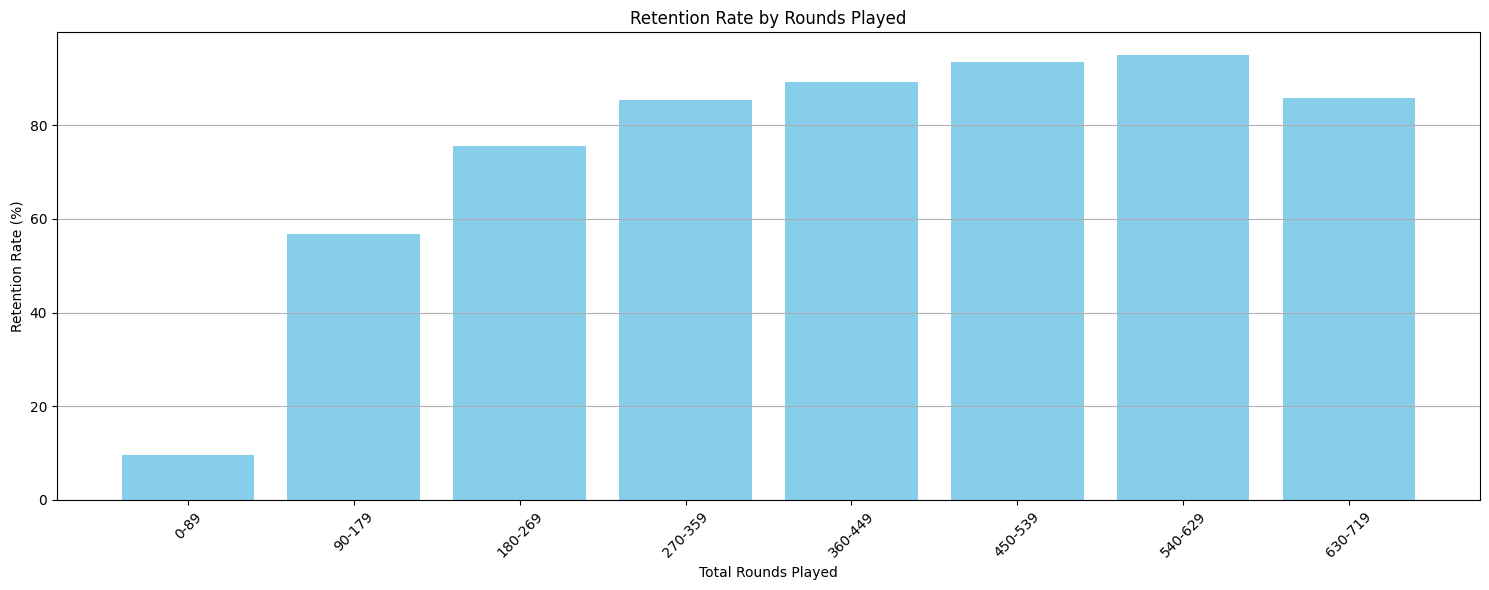

In [68]:
# Calculate the retention rate for each rounds played group
retention_rate_by_group = data_clean.groupby('rounds_bin')['retention_7'].mean() * 100

# Count the number of users in each group for context
user_count_by_group = data_clean.groupby('rounds_bin')['retention_7'].count()

# Plot the conversion rates against the number of ads viewed
plt.figure(figsize=(15, 6))
plt.bar(retention_rate_by_group.index, retention_rate_by_group.values, color='skyblue')
plt.title('Retention Rate by Rounds Played')
plt.xlabel('Total Rounds Played')
plt.ylabel('Retention Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [66]:
# Display the user count for each group
print("User Count by Rounds played:")
print(user_count_by_group)

User Count by Rounds played:
rounds_bin
0-89       76281
90-179      7749
180-269     2871
270-359     1438
360-449      720
450-539      427
540-629      264
630-719       14
Name: retention_7, dtype: int64


In [69]:
retention_user_by_rounds = pd.concat([retention_rate_by_group, user_count_by_group], axis=1).round(2)
retention_user_by_rounds.columns = ['Retention Rate', 'User Count']
retention_user_by_rounds

,Retention Rate,User Count
rounds_bin,,
0-89,9.52,76281
90-179,56.83,7749
180-269,75.62,2871
270-359,85.47,1438
360-449,89.17,720
450-539,93.44,427
540-629,95.08,264
630-719,85.71,14


**Accounting for Variability in User Segments: Weighted Conversion Rates and Confidence Intervals**

When the number of users in each segment varies significantly, it can lead to misleading conclusions if not properly accounted for. A more robust approach to interpreting these results involves normalizing or weighting the conversion rates by the number of users in each segment:
When the number of users in each ad exposure segment varies significantly, it can lead to misleading conclusions if not properly accounted for. To address this, we use a more robust approach by:
1. Calculating a weighted average conversion rate that accounts for the different sample sizes in each segment.
2. Calculating 95% confidence intervals for the conversion rates in each segment, providing a range in which the true conversion rate is likely to fall.

In [70]:
from scipy.stats import norm

# Function to calculate confidence intervals
def calculate_confidence_interval(count, nobs, alpha=0.05):
    """
    Calculate the confidence interval for a proportion.

    Parameters:
    count (int): Number of successes (e.g., conversions).
    nobs (int): Number of observations (e.g., total trials).
    alpha (float): Significance level (default is 0.05 for a 95% confidence interval).

    Returns:
    tuple: Proportion and margin of error as percentages.
    """
    proportion = count / nobs
    z = norm.ppf(1 - alpha / 2)  # Z-score for the given confidence level
    margin_of_error = z * np.sqrt((proportion * (1 - proportion)) / nobs)
    return proportion * 100, margin_of_error * 100

In [74]:
# Calculate conversion rates and confidence intervals for each segment
confidence_intervals = data_clean.groupby('rounds_bin', observed = False).apply(
    lambda x: calculate_confidence_interval(x['retention_7'].sum(), x['retention_7'].count()),
    include_groups=False
)

# Extract conversion rates and confidence intervals
retention_rates = confidence_intervals.apply(lambda x: x[0])
confidence_margin = confidence_intervals.apply(lambda x: x[1])

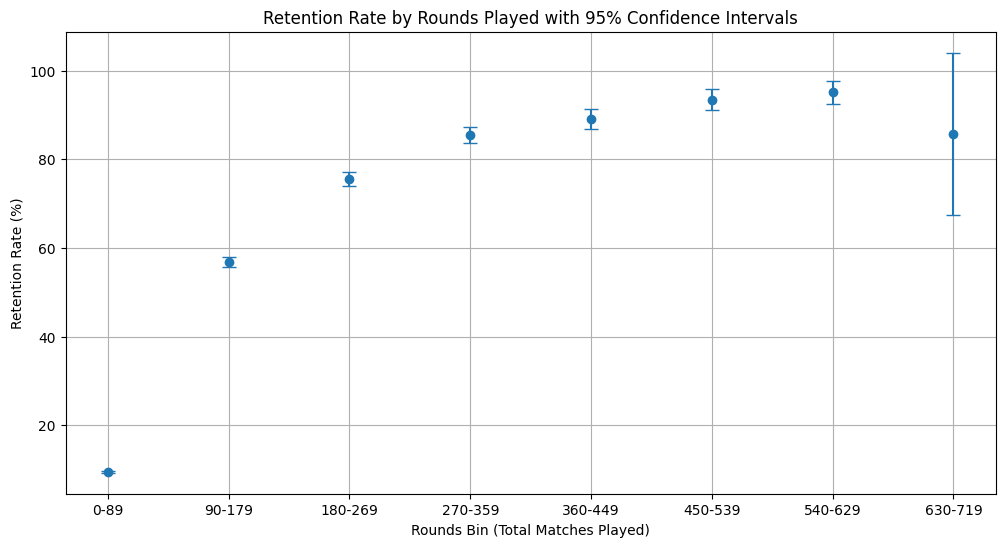

In [75]:
# Plot the conversion rates with confidence intervals
plt.figure(figsize=(12, 6))
plt.errorbar(retention_rates.index, retention_rates.values, yerr=confidence_margin.values, fmt='o', capsize=5)
plt.title('Retention Rate by Rounds Played with 95% Confidence Intervals')
plt.xlabel('Rounds Bin (Total Matches Played)')
plt.ylabel('Retention Rate (%)')
plt.grid(True)
plt.show()

In [76]:
# Display retention rates and confidence margins
retention_rates, confidence_margin

(rounds_bin
 0-89        9.520064
 90-179     56.833140
 180-269    75.618251
 270-359    85.465925
 360-449    89.166667
 450-539    93.442623
 540-629    95.075758
 630-719    85.714286
 dtype: float64,
 rounds_bin
 0-89        0.208274
 90-179      1.102812
 180-269     1.570642
 270-359     1.821624
 360-449     2.270200
 450-539     2.347858
 540-629     2.610061
 630-719    18.329966
 dtype: float64)

In [77]:
# Combine conversion rates and confidence intervals into a DataFrame
retention_rates_with_confidence = pd.concat([retention_user_by_rounds, confidence_margin], axis=1).round(2)
retention_rates_with_confidence.columns = ['Retention Rate', 'User Count','Confidence Interval']

# Display the DataFrame
retention_rates_with_confidence

,Retention Rate,User Count,Confidence Interval
rounds_bin,,,
0-89,9.52,76281,0.21
90-179,56.83,7749,1.10
180-269,75.62,2871,1.57
270-359,85.47,1438,1.82
360-449,89.17,720,2.27
450-539,93.44,427,2.35
540-629,95.08,264,2.61
630-719,85.71,14,18.33


Based on the provided data, the bin with the maximum retention rate is:

540-629 with a retention rate of 95.08%.

This bin also has a user count of 264 and a confidence interval of 2.61.

## Conclusion and Recommendations

---

### Overall Insights

Through our analysis of the marketing campaign data, several key insights have emerged:

**Gate Exposure and Effectiveness**:
---

- **gate_30 vs. gate_40**: The analysis shows that exposing players to gate 30 were more effective in retaining users than starting at gate 40 after the seventh day of playing. 
- **Increased Game Rounds Correlates with Higher Conversions**: Players who played more rounds were generally more likely to convert. This suggests that repeated exposure to game plays an important role in encouraging users to continue playing.
- **Optimal Game Rounds Range**: On the other hand, players who played between 540 and 629 rounds seems to be the sweet spot for players who would continue playing.

### Addressing the Key Questions

**1. Will the campaign be successful?**

The findings suggest that the campaign is likely to be successful if it is carefully planned. By starting players at easier gates ensures that players plays more rounds, the campaign can achieve significant results.

**2. If successful, how much of that success can be attributed to the gates?**

The analysis indicates that the gates contributed to the campaign's success only after the 7th day.

### Actionable Recommendations

**Focus Campaigns on Gate 30 or Easier Gates**:<br> Make players start at easier gates making it the most effective approach for campaigns.


### Limitations

**Data Constraints**: <br>
The analysis was limited to the variables available in the dataset. Factors like user demographics, ad content quality, and external influences (e.g., seasonality or promotions) are missing, potentially limiting the depth of the analysis.


### Final Thoughts

Gates are likely to play a crucial role in driving success.

Further analysis with more diverse data could help deepen the understanding of other factors that influence campaign success and refine these recommendations even further.

<div style="text-align: center;">
    <img src = "https://cdnb.artstation.com/p/assets/images/images/013/892/253/large/stefan-pruss-cats-workfile.jpg?1541540801" alt="Cookie" style="width: 1000px;" />
</div>